In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imread
from nansat import Nansat, Domain, Mosaic
from boreali import Boreali
import pandas as pd 
from IPython.display import Image

%matplotlib inline

In [2]:
# Test img file name path: ./data/A2014301181500.L2_LAC_OC.x.nc

# Bathymetry file path: ./data/michigan_lld.grd
# source https://www.ngdc.noaa.gov/mgg/greatlakes/michigan.html
# units: meters

n_img = Nansat('./data/A2014301181500.L2_LAC_OC.x.nc')
bathymetry = Nansat('./data/michigan_lld.grd')

dom = Domain('+proj=latlong +datum=WGS84 +ellps=WGS84 +no_defs', '-lle -86.3 44.6 -85.2 45.3 -ts 300 200')

n_img.reproject(dom)
bathymetry.reproject(dom)

=>michigan.grd<=


/home/artemm/Programs/Miniconda/miniconda2/envs/niersc/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater_equal


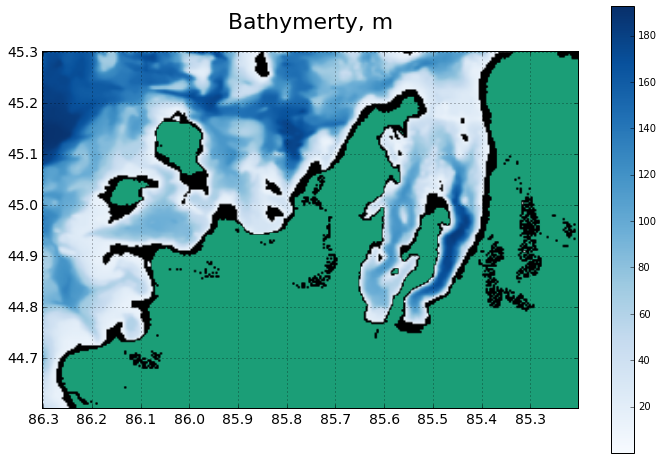

In [77]:
# plotting of bottom field
h = bathymetry[1]
h = np.where(h >= 0, np.nan, np.array(h) * -1)
h_mask = np.where(np.isfinite(h), np.nan, np.array(1))
h_10m = np.where(h >= 11, np.nan, np.array(1))

y = np.arange(0.0, 201.0, 200.0 / 7)
y_labels = np.arange(45.3, 44.5, -0.1)
x = np.arange(0.0, 301.0, 300.0 / 11)
x_labels = np.arange(86.3, 85.2, -0.1)

plt.figure(figsize=(12,8))
plt.title('Bathymerty, m', y=1.05, fontsize=22)
plt.imshow(h, cmap='Blues')
plt.yticks(y, y_labels)
plt.xticks(x, x_labels)
plt.tick_params(labelsize=14)
plt.colorbar()
# black field is area which depth less than 11 meters 
plt.imshow(h_10m,cmap='gray')

plt.imshow(h_mask, cmap='Dark2')
plt.grid(color='black')

Для проведения вычислений с разными комбинациями каналов использовались следующие наборы данных:

In [4]:
wavelens_base = [412, 443, 469, 488, 531, 547, 555, 645, 667, 678]   # All MODIS channels
wavelens_blue_off = [443, 469, 488, 531, 547, 555, 645, 667, 678]    # Without 412 nm
wavelens_1x1km_bands = [412, 443, 488, 531, 645, 678]   # Only 1 km spatial resolution bands. Need to try 547 band
wavelens_red_off = [412, 443, 469, 488, 531, 547, 555, 645, 667]    # Without 678 nm
wavelens_blueandred_off = [443, 469, 488, 531, 547, 555, 645, 667]   # Without 412 nm and 678 nm

Функция для расчета по алгоритму boreali (deep и osw):

In [5]:
def boreali_processing(n_img, wavelen, h, osw_mod='on'):
    """
    :param n_img: Nansat img
    :param wavelen: nupy array (vector) of wave lenghts
    :param h: numpy array of bottom deph was got from michigan_lld.grd
    :param osw_mod: Need I to use OSW ?  
    :return: numpy array custom_n which contain Rrs, Rrsw and CPA data
    """
    cpa_limits = [0.01, 3, 
                  0.01, 1, 
                  0.01, 1, 10]
    b = Boreali('michigan', wavelen)
    theta = np.zeros_like(n_img[2])
    custom_n = Nansat(domain=n_img)
    band_rrs_numbers = list(map(lambda x: n_img._get_band_number('Rrs_' + str(x)), wavelen)) 
    
    for index in range(0, len(wavelen)):
        rrsw = n_img[band_rrs_numbers[index]] / (0.52 + 1.7 * n_img[band_rrs_numbers[index]])   
        custom_n.add_band(rrsw, parameters={'name': 'Rrsw_' + str(wavelen[index]),  
                                            'units': 'sr-1',
                                            'wavelength': wavelen[index]})
        
        # If we want to use OSW mod, we will need to add Rrs data in custom_n obj
        if osw_mod == 'on':
            custom_n.add_band(n_img[band_rrs_numbers[index]], parameters={'name': 'Rrs_' + str(wavelen[index]),
                                                                          'units': 'sr-1',
                                                                          'wavelength': wavelen[index]})
    # Creating of the mask
    # All pixels marked as -0.015534 in img will marked as 0.0 in the mask
    mask = np.where(n_img[2] != np.float(-0.015534), np.array(64.0), np.array(0.0)) 
    # Validation of mask according to bathymetry data.
    # If in the bathymetry pixel was marked as np.nan, in mask he will marked as 0.0
    # else nothing
    mask = np.where(np.isnan(h), np.array(0.), mask)
    # Adding of mask into custom_n obj
    custom_n.add_band(mask, parameters={'name' : 'mask'})
    
    # h is trigger for OWS processing mod. 
    # If want to star OSW we will need to add h to Boreali.process
    # else marked as None
    if osw_mod == 'on': 
        depth = h
    else: 
        depth = None
    
    cpa = b.process(custom_n, cpa_limits,  mask=custom_n['mask'], depth=depth, theta=theta, threads=4)

    custom_n.add_band(array=cpa[0], parameters={'name': 'chl',
                                                'long_name': 'Chlorophyl-a',
                                                'units': 'mg m-3'})
    custom_n.add_band(array=cpa[1], parameters={'name': 'tsm',
                                                'long_name': 'Total suspended matter',
                                                'units': 'g m-3'})
    custom_n.add_band(array=cpa[2], parameters={'name': 'doc',
                                                'long_name': 'Dissolved organic carbon',
                                                'units': 'gC m-3'})
    custom_n.add_band(array=cpa[3], parameters={'name': 'mse',
                                                'long_name': 'Root Mean Square Error',
                                                'units': 'sr-1'})
    custom_n.add_band(array=cpa[4], parameters={'name': 'mask',
                                                'long_name': 'L2 Boreali mask',
                                                'units': '1'})
    
    #   custom_n.export(final_path + obj.split('/')[-1] + 'cpa_OSW.nc')
    return custom_n

In [6]:
def show_it(obj, name):
    plt.figure(figsize=(9,6))
    plt.imshow(obj, clim=[0., 3.])
    plt.colorbar()
    
    # Coordinate grid params
    y = np.arange(0.0, 201.0, 200.0 / 7)
    y_labels = np.arange(45.3, 44.5, -0.1)
    x = np.arange(0.0, 301.0, 300.0 / 11)
    x_labels = np.arange(86.3, 85.2, -0.1)
    
    plt.title(name, y=1.08, fontsize=16)
    plt.yticks(y, y_labels)
    plt.xticks(x, x_labels)
    plt.tick_params(labelsize=14)
    plt.imshow(h_mask, cmap='Dark2')
    plt.grid(color='black')

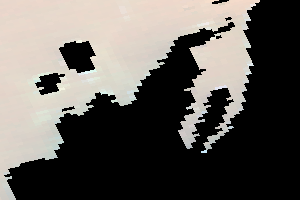

In [39]:
n_img.write_figure('test.png',[2,5,8], clim='hist')
Image(filename='test.png')

In [44]:
test8 = boreali_processing(n_img, wavelens_1x1km_bands, h, osw_mod='on')
test9 = boreali_processing(n_img, wavelens_1x1km_bands, h, osw_mod='off')

wavelen [412.0, 443.0, 488.0, 531.0, 645.0, 678.0]
R Name is  Rrs_
(6, 200, 300)
Pixels x bands to process:  (21714, 6)


launch shallow


launch shallow


launch shallow


launch shallow


spent:  38.4593868256


wavelen [412.0, 443.0, 488.0, 531.0, 645.0, 678.0]
R Name is  Rrsw_
(6, 200, 300)
Pixels x bands to process:  (21714, 6)


launch deep


launch deep


launch deep


launch deep


spent:  21.6938610077


In [42]:
test1 = boreali_processing(n_img, wavelens_base, h, osw_mod='on')
test2 = boreali_processing(n_img, wavelens_base, h, osw_mod='off')

wavelen [412.0, 443.0, 469.0, 488.0, 531.0, 547.0, 555.0, 645.0, 667.0, 678.0]
R Name is  Rrs_


(10, 200, 300)
Pixels x bands to process:  (21171, 10)


launch shallow


launch shallow


launch shallow


launch shallow


spent:  40.928221941


wavelen [412.0, 443.0, 469.0, 488.0, 531.0, 547.0, 555.0, 645.0, 667.0, 678.0]
R Name is  Rrsw_
(10, 200, 300)
Pixels x bands to process:  (21171, 10)


launch deep


launch deep


launch deep


launch deep


spent:  22.5724499226


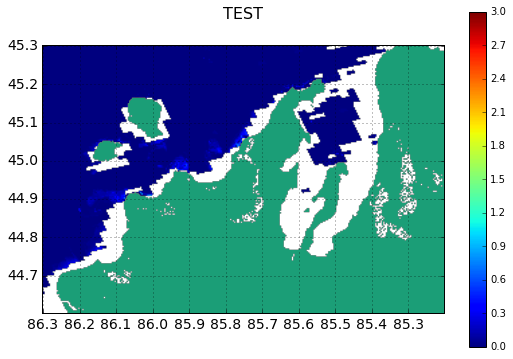

In [49]:
show_it(test1['chl']-test8['chl'], name='TEST')

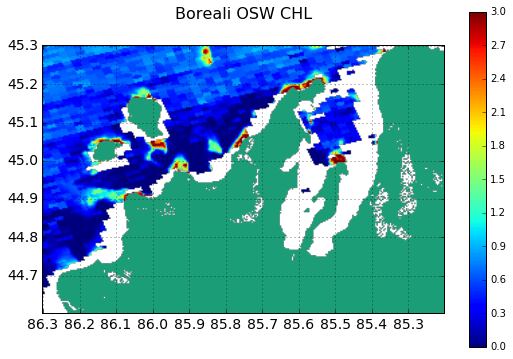

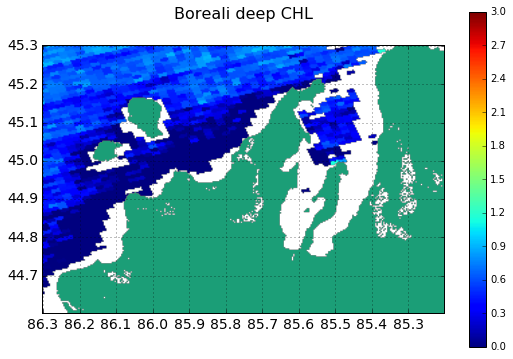

In [96]:
show_it(test['chl'], name='Boreali OSW CHL')
show_it(test2['chl'], name='Boreali deep CHL')

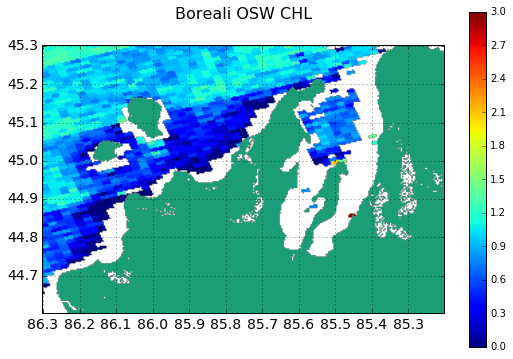

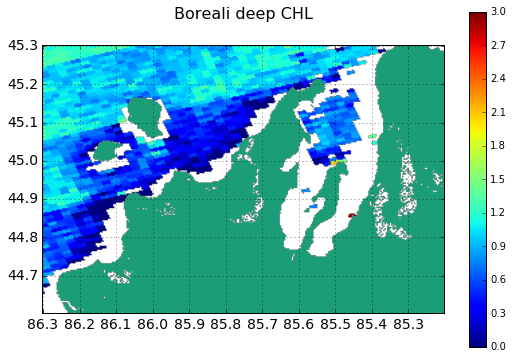

In [97]:
show_it(test3['chl'], name='Boreali OSW CHL')
show_it(test4['chl'], name='Boreali deep CHL')

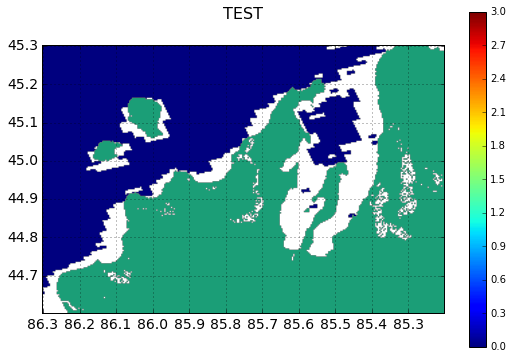

In [98]:
show_it(test3['chl'] - test4['chl'], name='TEST')

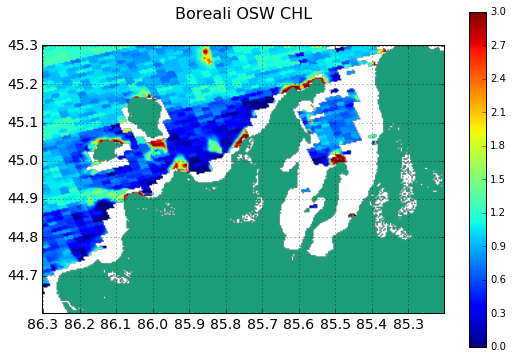

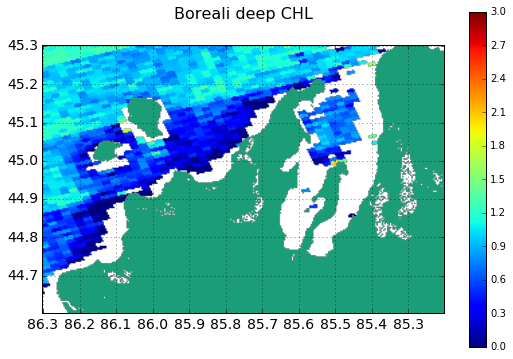

In [100]:
show_it(test5['chl'], name='Boreali OSW CHL')
show_it(test6['chl'], name='Boreali deep CHL')

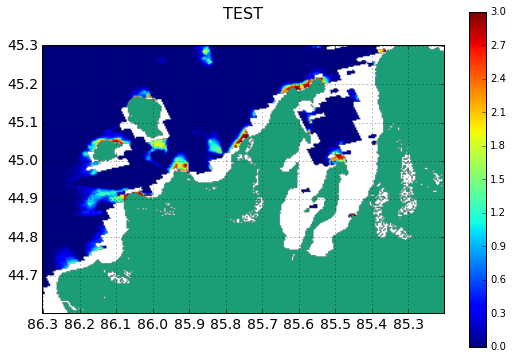

In [101]:
show_it(test5['chl'] - test6['chl'], name='TEST')

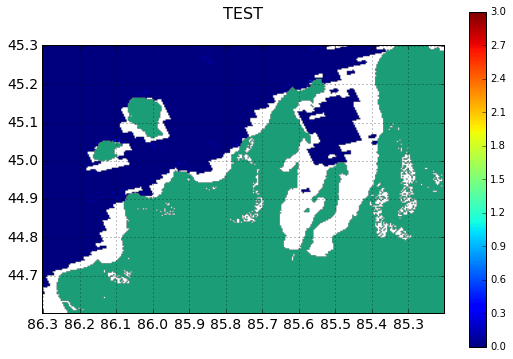

In [106]:
show_it(test['chl'] - test7['chl'], name='TEST')

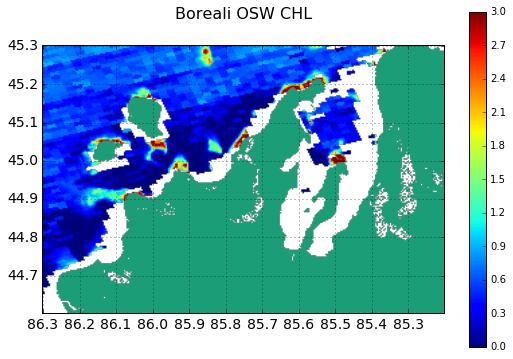

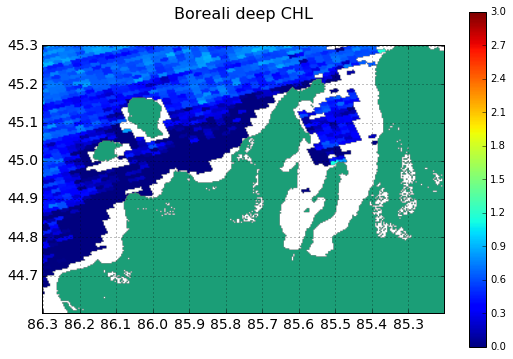

In [105]:
show_it(test7['chl'], name='Boreali OSW CHL')
show_it(test8['chl'], name='Boreali deep CHL')

In [81]:
lol = Nansat('/home/artemm/Downloads/Lake_Michigan_Contours.dbf')

07:08:52|40|nansat|_get_mapper|GDAL could not open /home/artemm/Downloads/Lake_Michigan_Contours.dbf, trying to read with Nansat mappers...


NansatReadError: /home/artemm/Downloads/Lake_Michigan_Contours.dbf: File cannot be read with NANSAT - consider writing a mapper

    fig_params = {'legend': True,
                  'LEGEND_HEIGHT': 0.5,
                  'NAME_LOCATION_Y': 0,
                  'mask_array': cpa[4],
                  'mask_lut': {1: [255, 255, 255],
                               2: [128, 128, 128],
                               4: [200, 200, 255]}}
    custom_n.write_figure(final_path + obj.split('/')[-1] + 'chl_OSW.png', 'chl', clim=[0, 1.], **fig_params)
    custom_n.write_figure(final_path + obj.split('/')[-1] + 'tsm_OSW.png', 'tsm', clim=[0, 1.], **fig_params)
    custom_n.write_figure(final_path + obj.split('/')[-1] + 'doc_OSW.png', 'doc', clim=[0, .2], **fig_params)
    custom_n.write_figure(final_path + obj.split('/')[-1] + 'mse_OSW.png', 'mse', clim=[1e-5, 1e-2],
                          logarithm=True, **fig_params)
    n.write_figure(final_path + obj.split('/')[-1] + 'rgb_OSW.png',
                   [16, 14, 6],
                   clim=[[0, 0, 0], [0.006, 0.04, 0.024]],
                   mask_array=cpa[4],
                   mask_lut={2: [128, 128, 128]})